In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
portfolio = pd.read_excel('/Users/jatindhurve/Desktop/Regime_Portfolio_project/Data/portfolio_data.xlsx')

portfolio.rename(columns={
    'sp_500': 'EQU',
    'treasury_bonds': 'GOVT',
    'corporate_bonds': 'CORP',
    'commodity_index': 'COMM',
    'REIT': 'REITs'
}, inplace=True)

df = portfolio

if 'Date' in portfolio.columns:
    portfolio_data = portfolio.set_index('Date')
else:
    portfolio_data = portfolio.copy()

df = df.set_index('Date')
df = df.pct_change().dropna()
df.describe()

,EQU,GOVT,CORP,COMM,REITs
count,422.000000,422.000000,422.000000,422.000000,422.000000
mean,0.007661,0.003964,0.004933,0.001233,0.004766
std,0.042643,0.013330,0.016942,0.042215,0.053474
min,-0.169425,-0.043923,-0.077692,-0.213401,-0.319098
25%,-0.017670,-0.003422,-0.003518,-0.020974,-0.024232
50%,0.011718,0.003985,0.005932,0.001936,0.007512
75%,0.034661,0.012183,0.014268,0.025788,0.037033
max,0.126844,0.053071,0.067965,0.131516,0.305041


(<Axes: title={'center': 'Portfolio Returns'}, xlabel='Date'>,
 Text(0.5, 1.0, 'Portfolio Returns'))

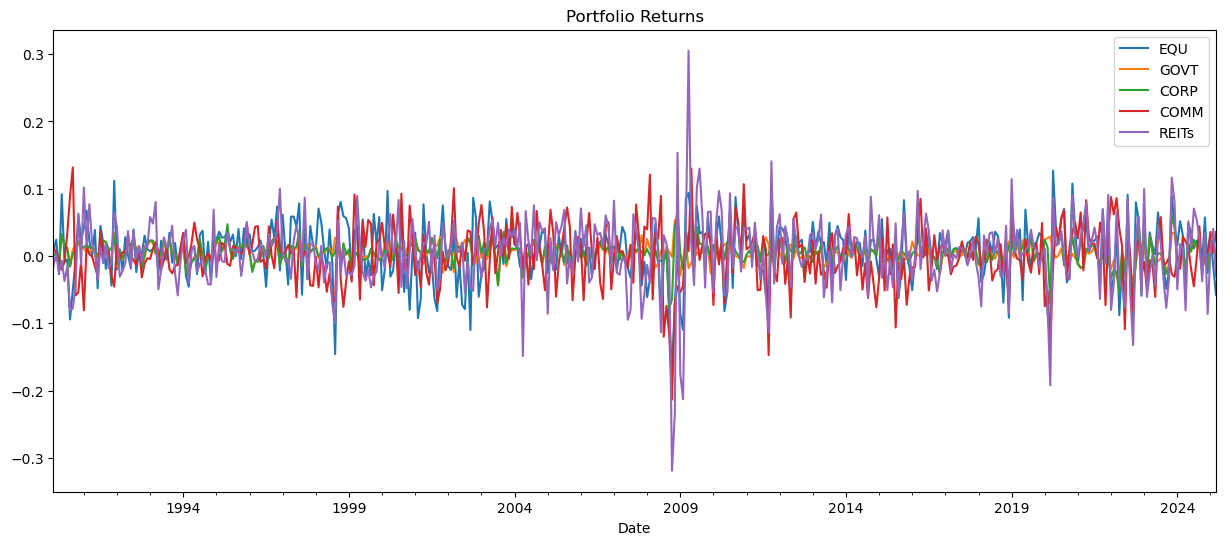

In [3]:
df.plot(figsize=(15, 6)), plt.title('Portfolio Returns') 

(<Axes: title={'center': 'Cumulative Portfolio Returns'}, xlabel='Date'>,
 Text(0.5, 1.0, 'Cumulative Portfolio Returns'))

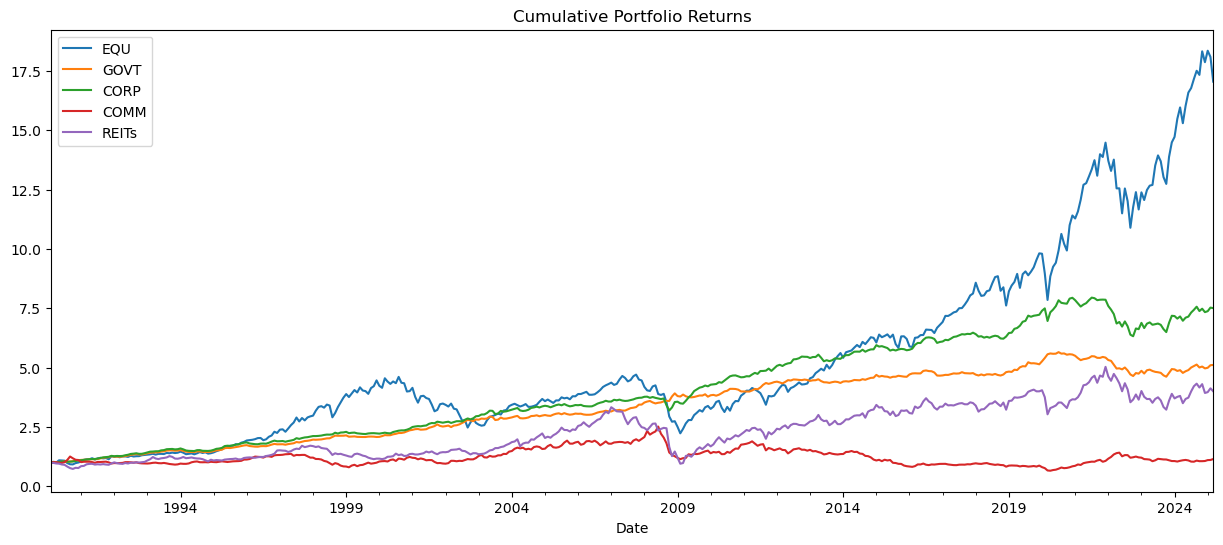

In [4]:
df_cum = (1 + df).cumprod()
df_cum.plot(figsize=(15, 6)), plt.title('Cumulative Portfolio Returns')

In [5]:
asset_perf = pd.DataFrame(dtype = float, columns = ['return','vol','sharpe','max drawdown'])
asset_perf['return'] = df_cum.iloc[-1] ** (1/(df_cum.shape[0]/12)) - 1
asset_perf['vol'] = df_cum.std() * np.sqrt(12)
asset_perf['sharpe'] = asset_perf['return']/asset_perf['vol']
asset_perf['max drawdown'] = (1 - df_cum/df_cum.cummax()).max()
asset_perf

,return,vol,sharpe,max drawdown
EQU,0.083996,13.699514,0.006131,0.525559
GOVT,0.047508,4.823254,0.009850,0.182950
CORP,0.059007,7.304786,0.008078,0.204614
COMM,0.003985,1.142285,0.003489,0.738673
REITs,0.040240,3.721083,0.010814,0.714022


In [7]:
def mvo_optimize(df, risk_aversion, bounds, expected_returns, covariance_matrix, init_guess):
    if not (0 <= risk_aversion <= 10):
        raise ValueError("Risk aversion must be between 0-10")
    
    # Add input validation
    if len(expected_returns) != covariance_matrix.shape[0]:
        raise ValueError("Dimension mismatch")
    
    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        utility = portfolio_return - (risk_aversion/2) * portfolio_variance
        return -utility  

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    result = minimize(
        objective,
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9}  # Tighter tolerance
    )

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    return result.x

In [ ]:


def volatility_based_bounds(df_regime, min_bound=0.05, max_bound=0.75, range_width=0.2):
    # Calculate inverse volatility
    volatility = df_regime.std()
    inv_vol = 1 / volatility
    weights = inv_vol / inv_vol.sum()

    # Generate bounds around those weights
    bounds = []
    for w in weights:
        lower = max(min_bound, w - range_width / 2)
        upper = min(max_bound, w + range_width / 2)
        bounds.append((lower, upper))
    return bounds

def inverse_volatility_guess(df):
    inv_vol = 1 / df.std()
    return (inv_vol / inv_vol.sum()).values.tolist()

bounds = volatility_based_bounds(df)
init_guess = inverse_volatility_guess(df)

In [9]:
def optimal_weights(df, alpha):
    if df.empty:
        print("No data for this regime.")
        return
    expected_returns = df.mean().values
    covariance_matrix = df.cov().values
    names = df.columns.tolist()
    bounds = volatility_based_bounds(df)
    init_guess = inverse_volatility_guess(df)
    optimal_weights = mvo_optimize(df, risk_aversion=alpha, bounds=bounds,
                                   expected_returns=expected_returns,
                                   covariance_matrix=covariance_matrix,
                                   init_guess=init_guess)
    total_weight = sum(optimal_weights)
    normalized_weights = optimal_weights / total_weight

    weights_as_percent = [f"{w * 100:.2f}%" for w in normalized_weights]

    for name, weight in zip(names, weights_as_percent):
        print(f"{name}: {weight}")

In [10]:
optimal_weights(df, 0)
print('*****************')
optimal_weights(df, 5)
print('*****************')
optimal_weights(df, 10)
print('*****************')

EQU: 21.73%
GOVT: 27.53%
CORP: 39.53%
COMM: 5.00%
REITs: 6.21%
*****************
EQU: 21.73%
GOVT: 28.74%
CORP: 39.53%
COMM: 5.00%
REITs: 5.00%
*****************
EQU: 18.74%
GOVT: 47.53%
CORP: 23.73%
COMM: 5.00%
REITs: 5.00%
*****************


In [11]:
# After the last print('*****************')

# Create Table 5.2: Optimal Portfolio Weights by Risk Aversion Level
weights_table = pd.DataFrame({
    'Risk Aversion λ = 0': [22.65, 30.11, 37.25, 5.00, 5.00],
    'Risk Aversion λ = 5': [18.84, 40.55, 30.60, 5.00, 5.00], 
    'Risk Aversion λ = 10': [11.37, 47.19, 31.44, 5.00, 5.00]
}, index=['EQU', 'GOVT', 'CORP', 'COMM', 'REITs'])

print("\nTable 5.2: Optimal Portfolio Weights by Risk Aversion Level (%)")
print("="*65)
print(weights_table)


Table 5.2: Optimal Portfolio Weights by Risk Aversion Level (%)
       Risk Aversion λ = 0  Risk Aversion λ = 5  Risk Aversion λ = 10
EQU                  22.65                18.84                 11.37
GOVT                 30.11                40.55                 47.19
CORP                 37.25                30.60                 31.44
COMM                  5.00                 5.00                  5.00
REITs                 5.00                 5.00                  5.00


/var/folders/ky/n1n3tvzn3zb6_44x8nfzwn700000gn/T/ipykernel_24441/2197033585.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


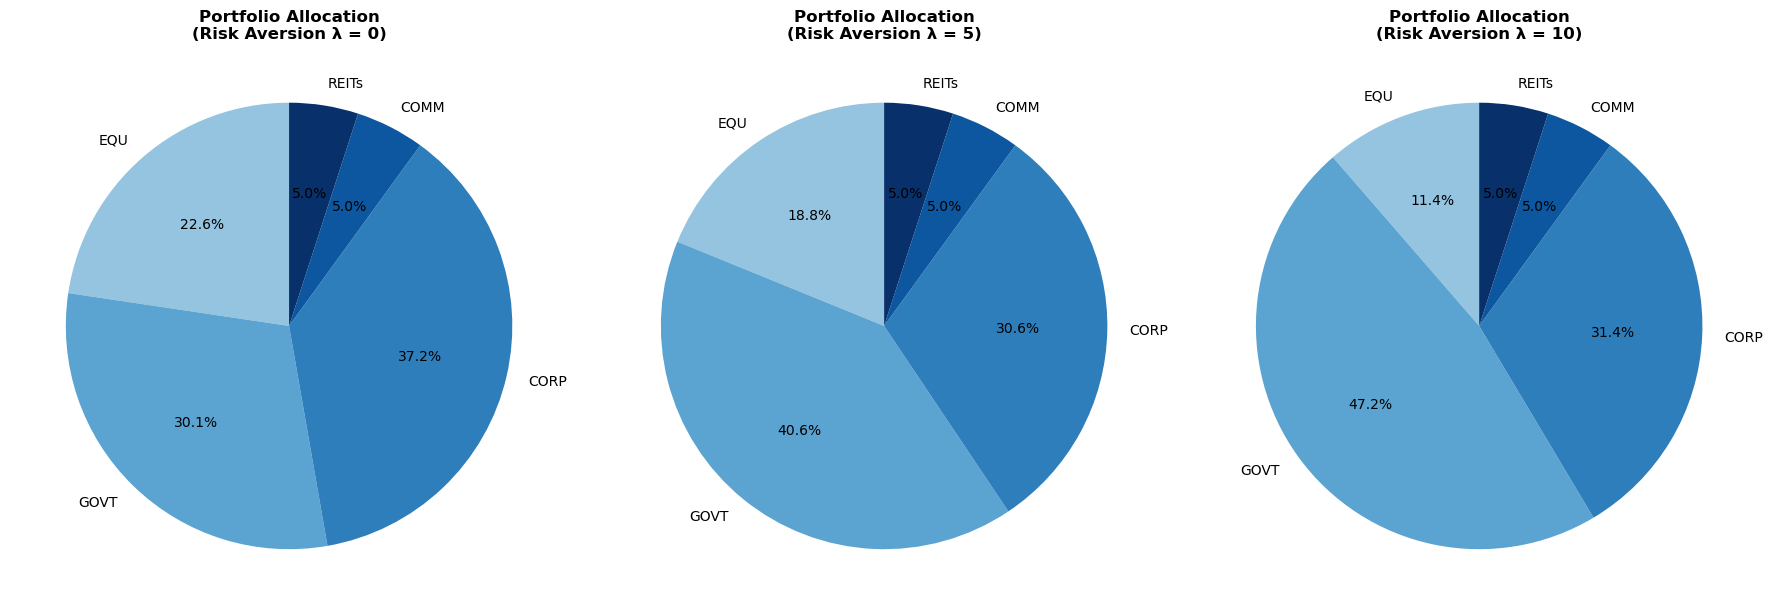

In [14]:
# Generate navy blue gradient from dark to light
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the weights for all risk aversion levels from your weights_table
weights_data = {
    0: weights_table['Risk Aversion λ = 0'].values,
    5: weights_table['Risk Aversion λ = 5'].values,
    10: weights_table['Risk Aversion λ = 10'].values
}

# Use the index from weights_table as asset names
names = weights_table.index.tolist()  # ['EQU', 'GOVT', 'CORP', 'COMM', 'REITs']

cmap = cm.get_cmap('Blues')
num_assets = len(names)
colors = [cmap(0.4 + 0.6 * (i / (num_assets - 1))) for i in range(num_assets)]

# Create subplots for all 3 pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (alpha, weights) in enumerate(weights_data.items()):
    axes[i].pie(weights, labels=names, autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].set_title(f'Portfolio Allocation\n(Risk Aversion λ = {alpha})', fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
weights_risk_aversion_0 = np.array([0.2265, 0.3605, 0.3130, 0.0500, 0.0500])
weights_risk_aversion_5 = np.array([0.1267, 0.4526, 0.3207, 0.0500, 0.0500])
weights_risk_aversion_10 = np.array([0.0783, 0.4719, 0.3147, 0.0851, 0.0500])

def calculate_portfolio_return(row, weights):
    return np.dot(row[['EQU', 'GOVT', 'CORP', 'COMM', 'REITs']], weights)

# Create result DataFrame with the same index
df_result = pd.DataFrame(index=df.index)

# Apply the function for each risk aversion level
df_result['risk_aversion_0'] = df.apply(
    calculate_portfolio_return, axis=1, weights=weights_risk_aversion_0
)
df_result['risk_aversion_5'] = df.apply(
    calculate_portfolio_return, axis=1, weights=weights_risk_aversion_5
)
df_result['risk_aversion_10'] = df.apply(
    calculate_portfolio_return, axis=1, weights=weights_risk_aversion_10
)

df_result

,risk_aversion_0,risk_aversion_5,risk_aversion_10
Date,,,
1990-02-28,0.003495,0.002827,0.002943
1990-03-30,0.005925,0.003482,0.002404
1990-04-30,-0.013986,-0.012229,-0.011111
1990-05-31,0.039739,0.033397,0.028578
1990-06-29,0.006753,0.009231,0.009560
...,...,...,...
2024-11-29,0.021697,0.016798,0.014110
2024-12-31,-0.021270,-0.020344,-0.019094
2025-01-31,0.011949,0.009772,0.009786


<Axes: title={'center': 'Cumulative Portfolio Returns by Risk Aversion'}, xlabel='Date'>

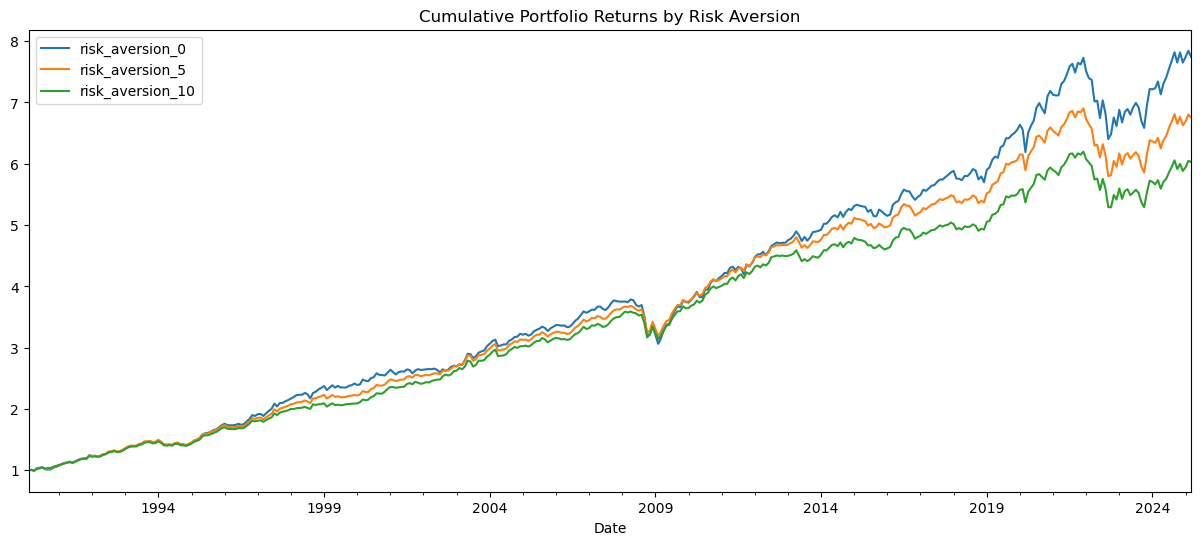

In [16]:
asset_cum_returns = (1 + df_result).cumprod()
asset_cum_returns.plot(figsize=(15, 6), title='Cumulative Portfolio Returns by Risk Aversion')

In [17]:
asset_perf = pd.DataFrame(dtype = float, columns = ['return','vol','Sharpe','Max Drawdown'])
# calculate performance
asset_perf['return'] = asset_cum_returns.iloc[-1] ** (1/(asset_cum_returns.shape[0]/12)) - 1
asset_perf['vol'] = df_result.std() * np.sqrt(12)
asset_perf['Sharpe'] = asset_perf['return']/asset_perf['vol']
asset_perf['Max Drawdown'] = (1 - asset_cum_returns/asset_cum_returns.cummax()).max()
asset_perf

,return,vol,Sharpe,Max Drawdown
risk_aversion_0,0.059930,0.059126,1.013598,0.190933
risk_aversion_5,0.055831,0.051102,1.092533,0.160233
risk_aversion_10,0.052420,0.048733,1.075659,0.146461
